In [2]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import time
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")



In [31]:
url = 'https://video.udacity-data.com/topher/2018/November/5bf60fbf_twitter-archive-enhanced/twitter-archive-enhanced.csv'
r = requests.get(url, allow_redirects=True)
open('twitter-archive-enhanced.csv', 'wb').write(r.content)

915692

## Gather Data


In [32]:
# load the provided enhanced twitter archive file into a DataFrame
df_t = pd.read_csv('twitter-archive-enhanced.csv')
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [33]:
df_t.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [34]:
S_Tweet = df_t.iloc[2]
S_Tweet

tweet_id                                                                                                                                                     891815181378084864
in_reply_to_status_id                                                                                                                                                       NaN
in_reply_to_user_id                                                                                                                                                         NaN
timestamp                                                                                                                                             2017-07-31 00:18:03 +0000
source                                                                                       <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
text                          This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never 

In [35]:
S_Tweet.text 

'This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB'

In [36]:
S_Tweet.expanded_urls

'https://twitter.com/dog_rates/status/891815181378084864/photo/1'

In [37]:
S_Tweet.source

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [38]:
# download the image predictions file with the provided link
url = 'https://video.udacity-data.com/topher/2018/November/5bf60fe7_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [39]:
f_images = url.split('/')[-1]

with open(os.path.join('./', f_images), mode = 'wb') as file:
    file.write(response.content)

In [40]:
ls *.tsv

 Volume in drive C has no label.
 Volume Serial Number is 1E26-A71D

 Directory of C:\Users\ITD\Untitled Folder

03/12/2021  07:00 PM           335,079 image-predictions.tsv
               1 File(s)        335,079 bytes
               0 Dir(s)  257,921,806,336 bytes free


In [41]:
# read image predictions file into a DataFrame
df_p = pd.read_csv(f_images, sep = '\\t', engine = 'python')
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [42]:
df_p.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [43]:
# check one observation
df_p.iloc[2]

tweet_id                                 666033412701032449
jpg_url     https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
img_num                                                   1
p1                                          German_shepherd
p1_conf                                            0.596461
p1_dog                                                 True
p2                                                 malinois
p2_conf                                            0.138584
p2_dog                                                 True
p3                                               bloodhound
p3_conf                                            0.116197
p3_dog                                                 True
Name: 2, dtype: object

In [44]:
CONSUMER_KEY = 'hide'
CONSUMER_SECRET = 'hide'
OAUTH_TOKEN = 'hide'
OAUTH_TOKEN_SECRET = 'hide'

In [45]:
# Create the Twitter API object and set rate limit params

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)




In [ ]:
api = tweepy.API(auth_handler = auth, 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)


In [46]:
# Get a list of tweet_ids from the enhanced twitter archive to use for 
# downloading with the Twitter API

tw_ids = df_t.tweet_id.values
print("# of tweet_ids: " +str(len(tw_ids)))

count = 0
tw_list = []
fails_dict = {}

start_time = time.time()

for tw_id in tw_ids:
    count += 1
    time.sleep(2)
    try:
        # attempt to get the tweet's JSON data and append to the tweet JSON list
        tw = api.get_status(tw_id, tweet_mode = 'extended')
        tw_list.append(tw._json)
    except tweepy.TweepError as err:
        # save the error to the fail dictionary for review
        print("TweepError for id:  " + str(tw_id) )
        fails_dict[tw_id] = err
        pass
    # To save space, only print out loop/tweet id for every 1000th tweet
    if count % 150 == 0:
        print("count per 150th tweet" + str(count))

e_time = time.time() - start_time

e_time_str = time.strftime("%H:%M:%S", time.gmtime(e_time))
print("\nTime elapsed (HH:MM:SS):  " + e_time_str + "\n")

# display list of tweets with errors
print("Number of TweepErrors:  {}\n".format(len(fails_dict)))
for tweet_id in fails_dict:
    print(tweet_id, fails_dict[tweet_id])

# of tweet_ids: 2356
TweepError for id:  888202515573088257
TweepError for id:  873697596434513921
TweepError for id:  872668790621863937
TweepError for id:  872261713294495745
TweepError for id:  869988702071779329
TweepError for id:  866816280283807744
count per 150th tweet150
TweepError for id:  861769973181624320
TweepError for id:  856602993587888130
TweepError for id:  851953902622658560
TweepError for id:  845459076796616705
TweepError for id:  844704788403113984
TweepError for id:  842892208864923648
TweepError for id:  837366284874571778
TweepError for id:  837012587749474308
count per 150th tweet300
TweepError for id:  829374341691346946
TweepError for id:  827228250799742977
count per 150th tweet450
TweepError for id:  812747805718642688
TweepError for id:  802247111496568832
count per 150th tweet600
count per 150th tweet750
TweepError for id:  779123168116150273
TweepError for id:  775096608509886464
TweepError for id:  771004394259247104
TweepError for id:  770743923962707

In [47]:
tweet_json_file = 'tweet_json.txt' 

In [48]:
# save the JSON data in the list to the output file
with open(tweet_json_file, 'w') as outfile:
    for tweet_json in tw_list:
        json.dump(tweet_json, outfile)
        outfile.write('\n')

In [49]:
ls tweet_json.txt

 Volume in drive C has no label.
 Volume Serial Number is 1E26-A71D

 Directory of C:\Users\ITD\Untitled Folder

03/12/2021  08:47 PM        10,533,928 tweet_json.txt
               1 File(s)     10,533,928 bytes
               0 Dir(s)  257,918,320,640 bytes free


In [50]:
# read in the JSON data from the text file, and save to a DataFrame
tw_data = []

with open(tweet_json_file, 'r') as json_file:
    # read the first line to start the loop
    line = json_file.readline()
    while line:
        data = json.loads(line)

        # extract variables from the JSON data
        d_id = data['id']
        d_retweet_count = data['retweet_count']
        d_favorite_count = data['favorite_count']
        
        # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': d_id, 
                     'retweet_count': d_retweet_count, 
                     'favorite_count': d_favorite_count
                    }
        tw_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- while -----

# convert the tweet JSON data dictionary list to a DataFrame
df_tw_1 = pd.DataFrame(tw_data, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

df_tw_1.head(30)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7349,35000
1,892177421306343426,5480,30307
2,891815181378084864,3624,22794
3,891689557279858688,7533,38268
4,891327558926688256,8119,36544
5,891087950875897856,2715,18432
6,890971913173991426,1758,10722
7,890729181411237888,16475,58948
8,890609185150312448,3769,25363
9,890240255349198849,6380,28949


In [51]:
df_tw_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [57]:
df_tw_1.to_csv('tweet_data_extra.csv', index = False)

## Assess Data

In [58]:

# Load the data gathered data files
work_sheet = pd.read_csv('twitter-archive-enhanced.csv')
dogs_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\\t', engine = 'python')
json_data = pd.read_csv('tweet_data_extra.csv')

In [54]:
work_sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

---
**NOTES:**

The `info()` method reveals several quality and tidiness issues:

- There are 181 retweets (**retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp**)
- There are 78 replies (**in_reply_to_status_id, in_reply_to_user_id**)
- There are 2297 tweets with **expanded_urls** (links to images) indicating 59 tweets with missing data
- The **timestamp** field is in string format (object)
- There are 4 columns for dog stages (**doggo, floofer, pupper, puppo**)


In [59]:
s_time=str(type(work_sheet.timestamp[0]))
print("Data type for timestamp:  " + s_time)

Data type for timestamp:  <class 'str'>


In [60]:
print("Duplicated:  {}".format(sum(work_sheet.duplicated())))

Duplicated:  0


In [61]:
work_sheet.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [62]:
work_sheet.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600524156928/photo/1,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090499244032/photo/1,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a Siberian heavily armored polar bear mix. Strong owner. 10/10 I would do unspeakable things to pet this dog https://t.co/rdivxLiqEt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525042405380/photo/1,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twi

**NOTES:**
> The `head()` and `tail()` methods show us several issues:
>
> Quality:
> - Some of the rows from the `tail()` output above have invalid strings in the **name** column, e.g. "a", "an", "the".
> - Values of "None" in the **name** column.
>
> Tidiness:
> - The columns with numerical data that are typically used for analysis are located to the far right of the table, and the columns with long strings are on the left; this makes it difficult to readily see the data that will be used for analyses.

In [64]:
work_sheet.name.value_counts().head(50)

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
Lucy         11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
the           8
Sadie         8
Toby          7
Bailey        7
an            7
Buddy         7
Daisy         7
Rusty         6
Jack          6
Leo           6
Koda          6
Scout         6
Oscar         6
Jax           6
Bella         6
Dave          6
Stanley       6
Milo          6
Bentley       5
Sammy         5
George        5
Sunny         5
Chester       5
Gus           5
Larry         5
Oakley        5
Phil          5
Alfie         5
very          5
Louis         5
Finn          5
Dexter        4
Reginald      4
Sampson       4
just          4
Duke          4
Moose         4
Beau          4
Luna          4
Name: name, dtype: int64

In [65]:
# list all names that are NOT capitalized
non_cap_names = work_sheet.name.str.contains('^[a-z]', regex = True)
work_sheet[non_cap_names].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [66]:
len(work_sheet[non_cap_names])

109

**NOTES:**

> This list contains non-capitalized words from the **name** column for 109 tweets, none of which are a valid name.


In [67]:
# number of tweets with missing urls
sum(work_sheet.expanded_urls.isna())

59

In [68]:
# how many tweets with missing urls are replies or retweets?
sum(work_sheet.expanded_urls.isna() & \
    (work_sheet.in_reply_to_status_id.notnull() | \
     work_sheet.retweeted_status_id.notnull()))

56

In [69]:
# display tweets that are missing urls, and are NOT replies and are NOT retweets
Missing = work_sheet.expanded_urls.isna() & \
       work_sheet.in_reply_to_status_id.isna() & \
       work_sheet.retweeted_status_id.isna()
work_sheet[Missing][['tweet_id', 'text', 'expanded_urls']]

,tweet_id,text,expanded_urls
375,828361771580813312,Beebop and Doobert should start a band 12/10 would listen,NaN
707,785515384317313025,"Today, 10/10, should be National Dog Rates Day",NaN
1445,696518437233913856,Oh my god 10/10 for every little hot dog pupper,NaN


NOTES:

Of the 59 tweets that are missing data in expanded_urls, 56 are replies or retweets. The remaining 3 tweets (at indexes 375, 707 and 1445) with NaN in the expanded_urls column all have valid ratings but no urls within the text column.

In [70]:
# are any of these tweets in the predictions table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
check_tweet_id = dogs_image_predictions.tweet_id.isin(tweet_set)
sum(check_tweet_id)

0

In [71]:
# are any of these tweets in the json_data table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
check_tweet_id = json_data.tweet_id.isin(tweet_set)
json_data[check_tweet_id]

,tweet_id,retweet_count,favorite_count
360,828361771580813312,172,2131
689,785515384317313025,1228,6017
1421,696518437233913856,1645,3771


In [72]:
work_sheet[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


NOTES:

For rating_numerator and rating_denominator, the describe() method shows us some quality issues:

The max values are huge: 1776, 170.
The minimum is 0 for both.

In [73]:
work_sheet.rating_denominator.value_counts().sort_index(ascending = False)

170       1
150       1
130       1
120       1
110       1
90        1
80        2
70        1
50        3
40        1
20        2
16        1
15        1
11        3
10     2333
7         1
2         1
0         1
Name: rating_denominator, dtype: int64

In [74]:
sum(work_sheet.rating_denominator != 10)

23

In [76]:
# display tweets that do NOT have denominator of 10,
# and are NOT replies and are NOT retweets
Missing_find = (work_sheet.rating_denominator != 10) & \
            work_sheet.in_reply_to_status_id.isna() & \
            work_sheet.retweeted_status_id.isna()

Missing_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
work_sheet[Missing_find][Missing_cols]

,text,tweet_id,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,820690176645140481,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,810984652412424192,24,7
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,758467244762497024,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,731156023742988288,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,713900603437621249,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,710658690886586372,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",709198395643068416,45,50


In [77]:
sum(Missing_find)

17

In [78]:
work_sheet.rating_numerator.value_counts().sort_index(ascending = False)

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

In [79]:
sum(work_sheet.rating_numerator >= 15)

28

In [80]:
df_tweets_denominator = work_sheet[work_sheet.rating_denominator == 10]
df_tweets_denominator.rating_numerator.value_counts().sort_index(ascending = False)

1776      1
666       1
420       2
182       1
75        2
27        1
26        1
17        1
15        2
14       54
13      351
12      558
11      463
10      461
9       156
8       102
7        54
6        32
5        37
4        15
3        19
2         9
1         8
0         2
Name: rating_numerator, dtype: int64

In [81]:
sum(df_tweets_denominator.rating_numerator >= 15)

12

In [87]:
# display tweets with numerator >= 15 that DO have denominator of 10,
# and are NOT replies and are NOT retweets
Missing_find = (work_sheet.rating_denominator == 10) & \
            (work_sheet.rating_numerator >= 15) & \
            work_sheet.in_reply_to_status_id.isna() & \
            work_sheet.retweeted_status_id.isna()

Missing_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
work_sheet[Missing_find][Missing_cols]

,text,tweet_id,rating_numerator,rating_denominator
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",786709082849828864,75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,778027034220126208,27,10
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,749981277374128128,1776,10
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,680494726643068929,26,10
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,670842764863651840,420,10


In [90]:
work_sheet.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

NOTES:

There are only 4 types of sources, and they can be simplified by using the display string portion just before the final "<\a>":

Twitter for iPhone
Vine - Make a Scene
Twitter Web Client
TweetDeck

In [91]:
work_sheet.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [92]:
work_sheet.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [93]:
work_sheet.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [94]:
work_sheet.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [95]:
work_sheet[work_sheet.floofer == 'floofer'].text

46       Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck https://t.co/rf661IFEYP
200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
582                                              This is Doc. He takes time out of every day to worship our plant overlords. 12/10 quite the floofer https://t.co/azMneS6Ly5
774                                         Atlas rolled around in some chalk and now he's a magical rainbow floofer. 13/10 please never take a bath https://t.co/nzqTNw0744
984                              This is Blu. He's a wild bush Floofer. I wish anything made me as happy as bushes make Blu. 12/10 would frolic with https://t.co/HHUAnBb6QB
1022                                   Here's a golden floofer helping with the groceries. Bed got in way. Still 11/10 helpful af (vid 

**NOTES:**
> Using the floofer category as an example, it looks like there are a few ways that this type is spelled: "floofer", "floofiest", and "Floofer".  
The other dog stage types may be similar in the variety of spelling.

In [96]:
dogs_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [97]:
dogs_image_predictions.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [98]:
dogs_image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [99]:
dogs_image_predictions.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [100]:
dogs_image_predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [101]:
# check out 20 of the entries that don't predict dogs
dogs_image_predictions[~dogs_image_predictions.p1_dog & \
               ~dogs_image_predictions.p2_dog & \
               ~dogs_image_predictions.p3_dog][['tweet_id', 'p1', 'p1_dog',
                                        'p2', 'p2_dog', 'p3', 'p3_dog']].head(20)

,tweet_id,p1,p1_dog,p2,p2_dog,p3,p3_dog
6,666051853826850816,box_turtle,False,mud_turtle,False,terrapin,False
17,666104133288665088,hen,False,cock,False,partridge,False
18,666268910803644416,desktop_computer,False,desk,False,bookcase,False
21,666293911632134144,three-toed_sloth,False,otter,False,great_grey_owl,False
25,666362758909284353,guinea_pig,False,skunk,False,hamster,False
29,666411507551481857,coho,False,barracouta,False,gar,False
45,666786068205871104,snail,False,slug,False,acorn,False
50,666837028449972224,triceratops,False,armadillo,False,common_iguana,False
51,666983947667116034,swab,False,chain_saw,False,wig,False
53,667012601033924608,hyena,False,African_hunting_dog,False,coyote,False


In [102]:
sum(~dogs_image_predictions.p1_dog & \
    ~dogs_image_predictions.p2_dog & \
    ~dogs_image_predictions.p3_dog)

324

In [103]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [104]:
json_data.head(20)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7349,35000
1,892177421306343426,5480,30307
2,891815181378084864,3624,22794
3,891689557279858688,7533,38268
4,891327558926688256,8119,36544
5,891087950875897856,2715,18432
6,890971913173991426,1758,10722
7,890729181411237888,16475,58948
8,890609185150312448,3769,25363
9,890240255349198849,6380,28949


In [105]:
json_data.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2586.717718,7308.686830
std,6.823170e+16,4375.594233,11351.743124
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,524.500000,1267.000000
50%,7.182469e+17,1206.000000,3170.000000
75%,7.986692e+17,2994.500000,8937.000000
max,8.924206e+17,74234.000000,150438.000000


Quality archive #1.

There are 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) and we need only to view original tweets.

Quality archive #2.

There are 78 reply tweets and we need only to view original tweets. Quality archive #3.¶

The timestamp column is in string format wrong data type.

Quality archive #4.

get value between and .

Quality archive #5

correct value for Some tweets that have wrong values for rating . 740373189193256964: 9/11 716439118184652801: 50/50 682962037429899265: 7/11 666287406224695296: 1/2

Quality archive #6

Some tweets with rating_denominator NOT equal to 10

Quality archive #7

There are 5 tweets with rating_numerator >= 15.

Quality archive #8.

Tweets with missing data in expanded_urls .

Quality archive 9

some tweets with some words in the name column that are NOT a valid name.

Tidiness archive #1

All columns related to “retweets” will be empty . Define Since we don't want retweets, we can remove all columns related to retweets: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

Tidiness archive #2.¶

All columns related to “replies” will be empty Define Drop all columns related to replies: in_reply_to_status_id and in_reply_to_user_id.

Tidiness archive #3.

There are 4 columns for dog stages: doggo, floofer, pupper, puppo.

Tidiness predictions #4.

breed prediction and associated confidence level can be combined with the work sheet table

Tidiness predictions #5

Drop the rating_denominator column as All values in the rating_denominator column are 10 Rename the rating_numerator column to be rating.

Tidiness archive #6.

Columns with numerical data are located to the far right of the table, which makes it difficult to readily see the data that will be used for analyses.

## Clean Data

In [106]:
# create copies of the dataframes for cleaning
work_sheet_clean = work_sheet.copy()
dogs_image_predictions_clean = dogs_image_predictions.copy()
json_quilty_clean = json_data.copy()

In [107]:
len_sheet = work_sheet_clean.shape[0]; len_sheet

2356

### Quality archive #1.


There are 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
and we need only to view original tweets.

Define
remove all rows containing retweets

Code

In [108]:
print("# of retweets:  {}".format(sum(work_sheet_clean.retweeted_status_id.notnull())))

# of retweets:  181


In [109]:
work_sheet_clean = work_sheet_clean[work_sheet_clean.retweeted_status_id.isna()]

In [110]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [111]:
# confirm the rows are dropped; compare with original table length
print("# of rows dropped:  {}".format(len_sheet - work_sheet_clean.shape[0]))
# reset the variable for length of the archive
len_sheet = work_sheet_clean.shape[0]

# of rows dropped:  181


### Quality archive #2.


There are 78 reply tweets and we need only to view original tweets.

Define
remove all rows that are replies 

Code

In [112]:
print("# of replies:  {}".format(sum(work_sheet_clean.in_reply_to_status_id.notnull())))

# of replies:  78


In [113]:
work_sheet_clean = work_sheet_clean[work_sheet_clean.in_reply_to_status_id.isna()]

In [114]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

In [115]:
# confirm the rows are dropped compare with previous table length
print("# of rows dropped:  {}".format(len_sheet - work_sheet_clean.shape[0]))
# reset the variable for length of the archive
len_sheet = work_sheet_clean.shape[0]

# of rows dropped:  78


### Tidiness archive #1

All columns related to “retweets” will be empty .

Define
Since we don't want retweets, we can remove all columns related to retweets: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

Code

In [116]:
work_sheet_clean = work_sheet_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

In [117]:
# Confirm all retweet related columns are gone
list(work_sheet_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Tidiness archive #2.

All columns related to “replies” will be empty 

Define
Drop all columns related to replies: in_reply_to_status_id and in_reply_to_user_id.

Code

In [118]:
work_sheet_clean = work_sheet_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis = 1)

In [119]:
# Confirm all reply related columns are gone
list(work_sheet_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Quality archive #3.

The timestamp column is in string format wrong data type.

Define
Convert timestamp to datetime data type.

In [120]:
work_sheet_clean['timestamp'] = pd.to_datetime(work_sheet_clean.timestamp)
work_sheet_clean['timestamp'] = work_sheet_clean.timestamp.dt.floor('s')

In [121]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Quality archive #4.

get value between `<a href="">` and `</a>`.

Define
remove unnecessary data and   get value between `<a href="">` and `</a>`.


In [122]:
work_sheet_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [123]:
work_sheet_clean['source'] = work_sheet_clean['source'].str.extract('^<a.+>(.+)</a>$')

In [124]:
work_sheet_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Quality archive #5 


correct value for Some tweets that have wrong values for rating .

Define
Manual fix:

740373189193256964: replace 9/11 with 14/10

716439118184652801: replace 50/50 with 11/10

682962037429899265: replace 7/11 with 10/10

666287406224695296: replace 1/2 with 9/10

Code

In [125]:
Missing_row = work_sheet_clean.tweet_id == 740373189193256964
work_sheet_clean.loc[Missing_row, 'rating_numerator'] = 14
work_sheet_clean.loc[Missing_row, 'rating_denominator'] = 10

In [126]:
Missing_row = work_sheet_clean.tweet_id == 716439118184652801
work_sheet_clean.loc[Missing_row, 'rating_numerator'] = 11
work_sheet_clean.loc[Missing_row, 'rating_denominator'] = 10

In [127]:
Missing_row = work_sheet_clean.tweet_id == 682962037429899265
work_sheet_clean.loc[Missing_row, 'rating_numerator'] = 10
work_sheet_clean.loc[Missing_row, 'rating_denominator'] = 10

In [128]:
Missing_row = work_sheet_clean.tweet_id == 666287406224695296
work_sheet_clean.loc[Missing_row, 'rating_numerator'] = 9
work_sheet_clean.loc[Missing_row, 'rating_denominator'] = 10

In [129]:
Missing_cols = ['tweet_id', 'text', 'rating_numerator', 'rating_denominator']
work_sheet_clean[(work_sheet_clean.tweet_id == 740373189193256964) | \
              (work_sheet_clean.tweet_id == 716439118184652801) | \
              (work_sheet_clean.tweet_id == 682962037429899265) | \
              (work_sheet_clean.tweet_id == 666287406224695296) ][Missing_cols]

,tweet_id,text,rating_numerator,rating_denominator
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10,10
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10


### Quality archive \#6
Some tweets with *rating_denominator* NOT equal to 10

##### Define
> remove the remaining tweets with `rating_denominator` values that are NOT equal to 10.
##### Code

In [130]:
# display denominators
work_sheet_clean.rating_denominator.value_counts().sort_index(ascending = False)

170       1
150       1
120       1
110       1
90        1
80        2
70        1
50        2
40        1
20        1
10     2084
7         1
Name: rating_denominator, dtype: int64

In [131]:
work_sheet_clean = work_sheet_clean[work_sheet_clean.rating_denominator == 10]

In [132]:
# check the values in the column - should only be "10"
work_sheet_clean.rating_denominator.value_counts().sort_index(ascending = False)

10    2084
Name: rating_denominator, dtype: int64

### Quality archive #7
There are 5 tweets with rating_numerator >= 15.

##### Define
> Remove tweets that have rating_numerator >= 15.
##### Code

In [133]:
# display numerators greater than 15
Missing = work_sheet_clean.rating_numerator >= 15
work_sheet_clean[Missing].rating_numerator.value_counts().sort_index(ascending = False)

1776    1
420     1
75      1
27      1
26      1
Name: rating_numerator, dtype: int64

In [134]:
work_sheet_clean = work_sheet_clean[work_sheet_clean.rating_numerator < 15]

In [135]:
# display ALL numerators
work_sheet_clean.rating_numerator.value_counts().sort_index(ascending = False)

14     39
13    287
12    486
11    414
10    437
9     153
8      98
7      51
6      32
5      34
4      15
3      19
2       9
1       4
0       1
Name: rating_numerator, dtype: int64

### Quality archive #8.
Tweets with missing data in expanded_urls .

##### Define
> Remove tweets with missing data in the `expanded_urls`.
##### Code

In [136]:
###Drop tweets with missing data in the `expanded_urls`.
work_sheet_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2079 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2079 non-null   int64              
 1   timestamp           2079 non-null   datetime64[ns, UTC]
 2   source              2079 non-null   object             
 3   text                2079 non-null   object             
 4   expanded_urls       2076 non-null   object             
 5   rating_numerator    2079 non-null   int64              
 6   rating_denominator  2079 non-null   int64              
 7   name                2079 non-null   object             
 8   doggo               2079 non-null   object             
 9   floofer             2079 non-null   object             
 10  pupper              2079 non-null   object             
 11  puppo               2079 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

In [137]:
work_sheet_clean = work_sheet_clean[work_sheet_clean.expanded_urls.notnull()]


In [138]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2076 non-null   int64              
 1   timestamp           2076 non-null   datetime64[ns, UTC]
 2   source              2076 non-null   object             
 3   text                2076 non-null   object             
 4   expanded_urls       2076 non-null   object             
 5   rating_numerator    2076 non-null   int64              
 6   rating_denominator  2076 non-null   int64              
 7   name                2076 non-null   object             
 8   doggo               2076 non-null   object             
 9   floofer             2076 non-null   object             
 10  pupper              2076 non-null   object             
 11  puppo               2076 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Tidiness archive #3.

There are 4 columns for dog stages: doggo, floofer, pupper, puppo.

Define
store the 4 columns with the dog stages:

Create column name 'none' to store the None values and  use lowercase 'n' to avoid confusion with 'None' special NA value.
Create a column stage to store dog stages: doggo, floofer, pupper, puppo,None. and select the stage from the column that contains a value.
Cast the stage column to categorical data type.
Drop the 4 original dog stage columns, and the temporary none column.
Code

In [139]:
#Melt the 4 columns with the dog stages:
work_sheet_clean[['doggo', 'floofer', 'pupper', 'puppo']].describe()

,doggo,floofer,pupper,puppo
count,2076,2076,2076,2076
unique,2,2,2,2
top,None,None,None,None
freq,1993,2066,1848,2052


In [140]:
# replace the stage name with 1, and 'None' with 0, like a dummy variable
make_dummy = lambda x: 0 if x == 'None' else 1

work_sheet_clean.doggo = work_sheet_clean.doggo.apply(make_dummy)
work_sheet_clean.floofer = work_sheet_clean.floofer.apply(make_dummy)
work_sheet_clean.pupper = work_sheet_clean.pupper.apply(make_dummy)
work_sheet_clean.puppo = work_sheet_clean.puppo.apply(make_dummy)

# by adding the stage columns, we can see how many are 'none' and how many stages are set
work_sheet_clean['none'] = work_sheet_clean['doggo'] + work_sheet_clean['floofer'] + \
                        work_sheet_clean['pupper'] + work_sheet_clean['puppo']

# have a look at what we have before we continue...
work_sheet_clean['none'].value_counts()

0    1742
1     323
2      11
Name: none, dtype: int64

In [141]:
# if there are NO stages specified then set 'None' to 1
stage_none = lambda x: 1 if x == 0 else 0

# reset values in 'none' 
work_sheet_clean['none'] = work_sheet_clean['none'].apply(stage_none)

# Order the stages in increasing count order: floofer, puppo, doggo and pupper
# set the choice order for dog stage based on count order
stage = ['floofer', 'puppo', 'doggo', 'pupper', 'none']

# set the conditions for selecting the dog stage based on count order
c = [
    (work_sheet_clean[stage[0]] == 1),
    (work_sheet_clean[stage[1]] == 1),
    (work_sheet_clean[stage[2]] == 1),
    (work_sheet_clean[stage[3]] == 1),
    (work_sheet_clean[stage[4]] == 1)]

# select the dog stage based on the first successful condition; stage[4] is 'None'
work_sheet_clean['stage'] = np.select(c, stage, default = stage[4])

# now we can drop the original 4 dog stage columns, AND the temporary 'None'
work_sheet_clean.drop(stage, axis = 1, inplace = True)

# set the 'stage' column data type to category
work_sheet_clean['stage'] = work_sheet_clean.stage.astype('category')



In [142]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2076 non-null   int64              
 1   timestamp           2076 non-null   datetime64[ns, UTC]
 2   source              2076 non-null   object             
 3   text                2076 non-null   object             
 4   expanded_urls       2076 non-null   object             
 5   rating_numerator    2076 non-null   int64              
 6   rating_denominator  2076 non-null   int64              
 7   name                2076 non-null   object             
 8   stage               2076 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 148.2+ KB


In [143]:
work_sheet_clean.stage.value_counts()

none       1742
pupper      219
doggo        81
puppo        24
floofer      10
Name: stage, dtype: int64

### Tidiness json_data & Quality json_data

add json_data to archive table.

There is also missing data in the Additional Cleaning part just below.

##### Define
> Merge the `retweet_count` and `favorite_count` columns to the work_sheet table, joining on `tweet_id`.
##### Code

In [147]:
#Merge the retweet_count and favorite_count columns to the archive table, joining on tweet_id.
json_quilty_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [148]:
work_sheet_clean = pd.merge(work_sheet_clean, json_quilty_clean, 
                         on = 'tweet_id', how = 'left')

In [149]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2075
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2076 non-null   int64              
 1   timestamp           2076 non-null   datetime64[ns, UTC]
 2   source              2076 non-null   object             
 3   text                2076 non-null   object             
 4   expanded_urls       2076 non-null   object             
 5   rating_numerator    2076 non-null   int64              
 6   rating_denominator  2076 non-null   int64              
 7   name                2076 non-null   object             
 8   stage               2076 non-null   category           
 9   retweet_count       2069 non-null   float64            
 10  favorite_count      2069 non-null   float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(3), object(4)
memory usage: 180.6+ KB

####  Cleaning Data
wrong data types for retweet_count and favorite_count need to change from float64 to int64.
There is also missing data for these fields.

##### Define
> - Remove tweets with missing **json_data**.
> - Change the data type for the `retweet_count` and `favorite_count` to be int.
##### Code

In [150]:
#Remove tweets with missing json_data.
#Change the data type for the retweet_count and favorite_count to be int.

Missing_cols = ['tweet_id', 'retweet_count', 'favorite_count']
work_sheet_clean[work_sheet_clean.retweet_count.isna() | work_sheet_clean.favorite_count.isna()][Missing_cols]

,tweet_id,retweet_count,favorite_count
90,872261713294495745,NaN,NaN
202,844704788403113984,NaN,NaN
234,837366284874571778,NaN,NaN
284,829374341691346946,NaN,NaN
570,779123168116150273,NaN,NaN
720,754011816964026368,NaN,NaN
1470,680055455951884288,NaN,NaN


In [151]:
work_sheet_clean = work_sheet_clean[~(work_sheet_clean.retweet_count.isna() | work_sheet_clean.favorite_count.isna())]

# recast the count columns to int type
work_sheet_clean.retweet_count = work_sheet_clean.retweet_count.astype(int)
work_sheet_clean.favorite_count = work_sheet_clean.favorite_count.astype(int)

In [152]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2075
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2069 non-null   int64              
 1   timestamp           2069 non-null   datetime64[ns, UTC]
 2   source              2069 non-null   object             
 3   text                2069 non-null   object             
 4   expanded_urls       2069 non-null   object             
 5   rating_numerator    2069 non-null   int64              
 6   rating_denominator  2069 non-null   int64              
 7   name                2069 non-null   object             
 8   stage               2069 non-null   category           
 9   retweet_count       2069 non-null   int32              
 10  favorite_count      2069 non-null   int32              
dtypes: category(1), datetime64[ns, UTC](1), int32(2), int64(3), object(4)
memory usage: 163.9+ KB


####  Quality archive 9

some tweets with some words in the name column that are NOT a valid name.

Define
Replace all lowercase words in the name column with the string "none".

In [153]:
#Replace all lowercase words in the name column with the string "none".
names_Missing = work_sheet_clean.name.str.contains('^[a-z]', regex = True)
work_sheet_clean[names_Missing].name.value_counts().sort_index()

a               54
actually         2
all              1
an               6
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             3
life             1
light            1
mad              1
my               1
not              2
officially       1
old              1
one              4
quite            3
space            1
such             1
the              8
unacceptable     1
very             4
Name: name, dtype: int64

In [154]:
work_sheet_clean.loc[names_Missing, 'name'] = "none"

In [155]:
# All these entries were changed to "none"
work_sheet_clean[names_Missing].name.value_counts().sort_index()

none    102
Name: name, dtype: int64

##### Define
> This is a 2-step process, first creating the columns in the **predictions** table, then merging to **archive**.
>
> Part 1:
> - Create two new columns in **predictions** called `breed` and `confidence`: check each dog breed prediction flag in order (`p1_dog`, `p2_dog`, `p3_dog`), and copy the breed with the highest confidence level into the `breed` column.
> - Copy the associated confidence level into the new `confidence` column.
> - For cases where all 3 prediction flags are False (NOT a valid dog breed), set `breed` as 'none' and `confidence` to 0.
>
> Part 2:
> - Merge the new `breed` and `confidence` columns into the tweet **archive** table, using an 'inner' join so that we are left with only tweets _with_ images.
> - Now we can fix the `confidence` column; round the values up to a whole number in percentage format.


### Tidiness predictions #4.
 breed prediction and associated confidence level can be combined with the work sheet table

We need to keep tweets that have images only

##### Define

> 1st:
> - Create two new columns in **predictions** called `breed` and `confidence`: check each dog breed prediction flag in order (`p1_dog`, `p2_dog`, `p3_dog`), and copy the breed with the highest confidence level into the `breed` column.
> - Copy the associated confidence level into the new `confidence` column.
> - change value to NOT a valid dog breed  where all 3 prediction flags  are false, set `breed` as 'none' and `confidence` to 0.
>
> 2nd:
> - Merge the new `breed` and `confidence` columns into the tweet work sheet table, using an 'inner' join so that we are left with only tweets _with_ images.




In [156]:

# setup the conditions for selection
c = [(dogs_image_predictions_clean['p1_dog'] == True),
              (dogs_image_predictions_clean['p2_dog'] == True),
              (dogs_image_predictions_clean['p3_dog'] == True)]

# set the choice order based on the selection conditions for predicted breed
c_breed = [dogs_image_predictions_clean['p1'], 
                 dogs_image_predictions_clean['p2'],
                 dogs_image_predictions_clean['p3']]

# set the choice order for confidence level based on the selection conditions
c_confidence = [dogs_image_predictions_clean['p1_conf'], 
                      dogs_image_predictions_clean['p2_conf'], 
                      dogs_image_predictions_clean['p3_conf']]

# select the predicted breed based on the first successful condition
dogs_image_predictions_clean['breed'] = np.select(c, c_breed, 
                                       default = 'none')

# select the predicted confidence level based on the first successful condition
dogs_image_predictions_clean['confidence'] = np.select(c, c_confidence, 
                                            default = 0)

In [157]:
dogs_image_predictions_clean.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,none,0.000000
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True,miniature_poodle,0.201493


In [158]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2075
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2069 non-null   int64              
 1   timestamp           2069 non-null   datetime64[ns, UTC]
 2   source              2069 non-null   object             
 3   text                2069 non-null   object             
 4   expanded_urls       2069 non-null   object             
 5   rating_numerator    2069 non-null   int64              
 6   rating_denominator  2069 non-null   int64              
 7   name                2069 non-null   object             
 8   stage               2069 non-null   category           
 9   retweet_count       2069 non-null   int32              
 10  favorite_count      2069 non-null   int32              
dtypes: category(1), datetime64[ns, UTC](1), int32(2), int64(3), object(4)
memory usage: 163.9+ KB


In [159]:
# merge the breed and confidence columns to archive
Missing_cols = ['tweet_id', 'breed', 'confidence']
work_sheet_clean = pd.merge(work_sheet_clean, dogs_image_predictions_clean[Missing_cols],
                         on = 'tweet_id', how = 'inner')

# change data type for the confidence interval to a rounded, whole integer (%)
work_sheet_clean.confidence = (work_sheet_clean.confidence * 100).astype(int)

# after the two columns are merged, we can drop them from the 'predictions' table
dogs_image_predictions_clean.drop(['breed', 'confidence'], axis = 1, inplace = True)

In [160]:
work_sheet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 1945
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1946 non-null   int64              
 1   timestamp           1946 non-null   datetime64[ns, UTC]
 2   source              1946 non-null   object             
 3   text                1946 non-null   object             
 4   expanded_urls       1946 non-null   object             
 5   rating_numerator    1946 non-null   int64              
 6   rating_denominator  1946 non-null   int64              
 7   name                1946 non-null   object             
 8   stage               1946 non-null   category           
 9   retweet_count       1946 non-null   int32              
 10  favorite_count      1946 non-null   int32              
 11  breed               1946 non-null   object             
 12  confidence          1946 non-null 

In [161]:
work_sheet_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,none,7349,35000,none,0
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,none,5480,30307,Chihuahua,32
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,none,3624,22794,Chihuahua,71
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,none,7533,38268,Labrador_retriever,16
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,none,8119,36544,basset,55


In [162]:
list(dogs_image_predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

### Tidiness predictions #5

Drop the rating_denominator column as All values in the rating_denominator column are 10

Rename the rating_numerator column to be rating.

Define

Drop the rating_denominator column.

Rename the rating_numerator column to be rating.

In [163]:
##Drop the rating_denominator column.
##Rename the rating_numerator column to be rating.
work_sheet_clean.rating_denominator.value_counts()

10    1946
Name: rating_denominator, dtype: int64

In [164]:
work_sheet_clean.drop(['rating_denominator'], axis = 1, inplace = True)
work_sheet_clean.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

In [165]:
list(work_sheet_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating',
 'name',
 'stage',
 'retweet_count',
 'favorite_count',
 'breed',
 'confidence']

### Tidiness `archive` \#6.
Columns with numerical data are located to the far right of the table, which makes it difficult to readily see the data that will be used for analyses.

##### Define
> - Reorder the column placement: bring numerical columns to the left.
> - Drop the `expanded_urls` column.

##### Code

In [184]:
col_list = list(work_sheet_clean.columns)
print(col_list)

['tweet_id', 'timestamp', 'rating', 'breed', 'confidence', 'name', 'stage', 'source', 'text']


In [186]:
# set the columns in a new order
col_list = ['tweet_id', 'timestamp', 'rating',
            'breed', 'confidence', 'name', 'stage', 'source', 'text']

work_sheet_clean = work_sheet_clean[col_list]

In [187]:
work_sheet_clean.head(2)

,tweet_id,timestamp,rating,breed,confidence,name,stage,source,text
0,892420643555336193,2017-08-01 16:23:56+00:00,13,none,0,Phineas,none,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27+00:00,13,Chihuahua,32,Tilly,none,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"


In [188]:
#store the work_sheet table into the 'twitter_archive_master.csv' file.
work_sheet_clean.to_csv('twitter_archive_master.csv', index = False)

In [189]:
ls *.csv

 Volume in drive C has no label.
 Volume Serial Number is 1E26-A71D

 Directory of C:\Users\ITD\Untitled Folder

03/12/2021  08:52 PM            68,623 tweet_data_extra.csv
03/12/2021  09:12 PM           424,135 twitter_archive_master.csv
03/12/2021  07:00 PM           915,692 twitter-archive-enhanced.csv
               3 File(s)      1,408,450 bytes
               0 Dir(s)  257,712,005,120 bytes free


Analyze Data

In [190]:
# Set default display parameter for plots.
plt.rcParams['figure.figsize'] = (8, 5)

In [191]:
# make a copy of the archive master table for analysis
rate_dog_project = work_sheet_clean.copy()
rate_dog_project.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 1945
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_id    1946 non-null   int64              
 1   timestamp   1946 non-null   datetime64[ns, UTC]
 2   rating      1946 non-null   int64              
 3   breed       1946 non-null   object             
 4   confidence  1946 non-null   int32              
 5   name        1946 non-null   object             
 6   stage       1946 non-null   category           
 7   source      1946 non-null   object             
 8   text        1946 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), int32(1), int64(2), object(4)
memory usage: 131.3+ KB


In [192]:
# time range for tweets
rate_dog_project.timestamp.min(), rate_dog_project.timestamp.max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

In [193]:
rate_dog_project[['rating', 'confidence']].describe()

,rating,confidence
count,1946.000000,1946.000000
mean,10.532888,46.026721
std,2.174684,33.813815
min,0.000000,0.000000
25%,10.000000,14.000000
50%,11.000000,45.000000
75%,12.000000,77.000000
max,14.000000,99.000000


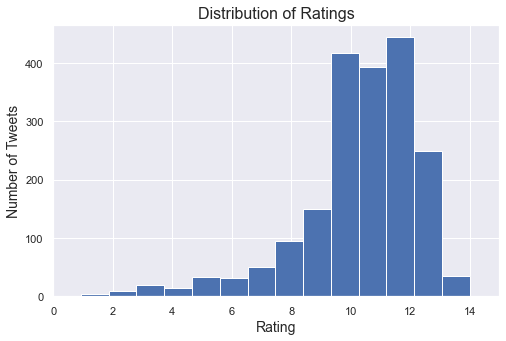

In [194]:
rate_dog_project['rating'].plot(kind = 'hist', bins = 15)

plt.xlim(0, 15)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

In [195]:
# Percentage of tweets with rating of 10 and up
rating_10up_total = sum(rate_dog_project.rating >= 10)
rating_10up_perc = round(rating_10up_total * 100 / rate_dog_project.shape[0])
print("Number of tweets with rating 10+:  {}".format(rating_10up_total))
print("Percentage of tweets:                {}%".format(round(rating_10up_perc, 3)))

Number of tweets with rating 10+:  1537
Percentage of tweets:                79%


In [196]:
rate_dog_project.stage.value_counts()

none       1645
pupper      200
doggo        70
puppo        23
floofer       8
Name: stage, dtype: int64

In [197]:
with_stage_sum = sum(rate_dog_project.stage != 'none')
tweets_with_stage = round(with_stage_sum * 100 / rate_dog_project.shape[0])
print("Number of tweets WITH stage:  {}".format(with_stage_sum))
print("Percentage of tweets:          {}%".format(round(tweets_with_stage, 3)))

Number of tweets WITH stage:  301
Percentage of tweets:          15%


In [198]:
str = "Number of tweets with 'none' predicted breed:  {} ({}%)"
none_count = sum(rate_dog_project.breed == 'none')
none_perc = none_count * 100 / rate_dog_project.shape[0]
print(str.format(none_count, round(none_perc)))

str = "Number of distinct breeds:  {}"
print(str.format(len(rate_dog_project.breed.unique())))

Number of tweets with 'none' predicted breed:  302 (16%)
Number of distinct breeds:  113


In [199]:
top10_breeds_count = \
rate_dog_project[rate_dog_project.breed != 'none'].breed.value_counts().head(10)
print("Breed and number of tweets")
print("--------------------------")
print(top10_breeds_count)

top10_per = round(sum(top10_breeds_count) * 100 / rate_dog_project.shape[0])
print("\nTop 10 dog breeds make up {}% of all tweets".format(top10_per))

Breed and number of tweets
--------------------------
golden_retriever      154
Labrador_retriever    101
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   47
Samoyed                41
Pomeranian             40
malamute               33
Name: breed, dtype: int64

Top 10 dog breeds make up 37% of all tweets


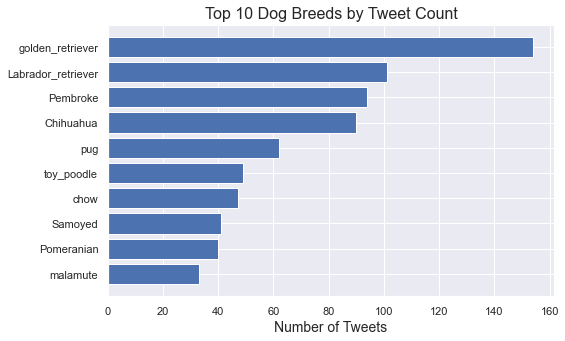

In [200]:
plt.barh(top10_breeds_count.index, top10_breeds_count)

plt.xlabel('Number of Tweets', fontsize = 14)
# plt.ylabel('Dog Breed', fontsize = 14)
plt.title('Top 10 Dog Breeds by Tweet Count', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();